# (INFO-F422) Statistical foundations of machine learning: Project 24-25

description: regression task, predict continuous hand proshtesis movement through short time-windows hand pose (angles) from forearm electrode sensors. 

+ author 1
+ author 2
+ author 3

__TODO__: 
+ std dev in addition to avg fro cv scores (may prefere slightly higher cv but with lower var)
+ eval metrics interpretation, ...

___

## Imports

In [3]:
# models
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

# model selection
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.decomposition import PCA

# preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

# pip install -U skorch
import torch
import torch.nn as nn
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from skorch.callbacks import LRScheduler

# utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

___

## Data loading

In [4]:
data_dir = ".." # "data"
pred_dir = "results"

X_g_train = np.load(f"{data_dir}/guided/guided_dataset_X.npy")
y_g_train = np.load(f"{data_dir}/guided/guided_dataset_y.npy")
X_g_test = np.load(f"{data_dir}/guided/guided_testset_X.npy")

X_f_train = np.load(f"{data_dir}/freemoves/freemoves_dataset_X.npy")
y_f_train = np.load(f"{data_dir}/freemoves/freemoves_dataset_y.npy")
X_f_test = np.load(f"{data_dir}/freemoves/freemoves_testset_X.npy")


In [5]:
print("Guided:")
print(f"X_g_train {X_g_train.shape} / y_g_train{y_g_train.shape} / X_g_test{X_g_test.shape}\n")
print("Free moves:")
print(f"X_f_train{X_f_train.shape} / y_f_train{y_f_train.shape} / X_f_test{X_f_test.shape}")

Guided:
X_g_train (5, 8, 230000) / y_g_train(5, 51, 230000) / X_g_test(5, 332, 8, 500)

Free moves:
X_f_train(5, 8, 270000) / y_f_train(5, 51, 270000) / X_f_test(5, 308, 8, 500)


#### Filtering 

In [50]:
from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def filter_data_3d(data: np.ndarray, lowcut: float, highcut: float, fs: float, order: int = 4) -> np.ndarray:

    b, a = butter_bandpass(lowcut, highcut, fs, order)
    filtered = np.empty_like(data)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            filtered[i, j, :] = filtfilt(b, a, data[i, j, :])
    return filtered

def filter_data_4d(data: np.ndarray, lowcut: float, highcut: float, fs: float, order: int = 4) -> np.ndarray:

    b, a = butter_bandpass(lowcut, highcut, fs, order)
    filtered = np.empty_like(data)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                filtered[i, j, k, :] = filtfilt(b, a, data[i, j, k, :])
    return filtered

X_g_train = filter_data_3d(X_g_train, lowcut=0.5, highcut=40, fs=250)
X_f_train = filter_data_3d(X_f_train, lowcut=0.5, highcut=40, fs=250)
X_g_test = filter_data_4d(X_g_test, lowcut=0.5, highcut=40, fs=250)
X_f_test = filter_data_4d(X_f_test, lowcut=0.5, highcut=40, fs=250)

___

## Data preparation

At the beginning, we implemented a naive function that loops for each windows needed. 

This version work but:
- Only when the step size can divides the total number of samples.  
- Copies every window into a new array, incurring  CPU overhead and unnecessary memory usage.

But after some research, we decided to use the sliding_window_view function from the Numpy library for several reasons:

+ Fast vectorized numpy operations, compiled c-code (no python overhead, interpreter).

+ sliding_window_view function returns a view, no copy.

+ The function simplifies the implementation by automating window creation and indexing.

In [51]:
class XWindowAugment(BaseEstimator, TransformerMixin):
    """
    Augment X through overlapping windows
    """
    
    def __init__(self, window_size=500, overlap=0.5):
        self.window_size = window_size
        self.overlap = overlap
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        axis = 2 # time
        step = int(self.window_size * (1 - self.overlap))
        
        # sliding_windows_view Generate all possible windows with the corresponding step, that not what we want.
        X_windows = np.lib.stride_tricks.sliding_window_view(X,self.window_size, axis)

        # only keep windows where the step is a multiple of our step 
        X_windows = X_windows[:,:,::step,:]
         
        # (session, electrode, window, time) to (session, window, electrode, time)
        X_windows = X_windows.transpose(0, 2, 1, 3) 
        
        return X_windows   

In [52]:
class yWindowAugment(BaseEstimator, TransformerMixin):
    """
    + Augment y through overlapping windows 
    + Extract target of correspondoing windows
    """
    
    def __init__(self, window_size=500, overlap=0.5):
        self.window_size = window_size
        self.overlap = overlap
    
    def fit(self, y, X=None):
        return self
    
    def transform(self, y, X=None):
        axis = 2 # time
        step = int(self.window_size * (1 - self.overlap))
        
        # ----- window augment -----
        
        # sliding_windows_view Generate all possible windows with the corresponding step, that not what we want.
        y_windows = np.lib.stride_tricks.sliding_window_view(y,self.window_size, axis)

        # only keep windows where the step is a multiple of our step 
        y_windows = y_windows[:,:,::step,:]
         
        # (session, angles, window, time) to (session, window, angles, time)
        y_windows = y_windows.transpose(0, 2, 1, 3)     
        
        # ----- target extract -----
        
        y_windows = y_windows[:, :, :, -1] # keep last hand pose as window target
        
        return y_windows

Prepared data

In [53]:
X_g_train_wdw = XWindowAugment().transform(X_g_train)
y_g_train_wdw = yWindowAugment().transform(y_g_train)

X_f_train_wdw = XWindowAugment().transform(X_f_train)
y_f_train_wdw = yWindowAugment().transform(y_f_train)

print("Guided windowed:")
print(f"X_g_train_wdw {X_g_train_wdw.shape} / X_g_test {X_g_test.shape}")
print(f"y_g_train_wdw{y_g_train_wdw.shape}\n")

print("Free moves windowed:")
print(f"X_f_train_wdw {X_f_train_wdw.shape} / X_f_test {X_f_test.shape}")
print(f"y_f_train_wdw{y_f_train_wdw.shape}")

Guided windowed:
X_g_train_wdw (5, 919, 8, 500) / X_g_test (5, 332, 8, 500)
y_g_train_wdw(5, 919, 51)

Free moves windowed:
X_f_train_wdw (5, 1079, 8, 500) / X_f_test (5, 308, 8, 500)
y_f_train_wdw(5, 1079, 51)


___

## Evaluation metrics


+ RMSE = $\frac{x}{y}$
    - low
    + high

+ NMSE
    - low
    + high


___

## Cross validation strategy

For this question, we have thought about various methods of cross validation. First, our data are continous because it's a signal, so preserving temporal structure is important. We can’t use a method of cross validation which randomly shuffles our windows. 

We also need to prevents data leaking so we can't use a methode who use the windows of one session for training AND validation because we have overlapping data in each session, two windows in the same session can share the same datas, and if these two windows are in train and validation, it will lead to data leakage and overly optimistic performance (data in the train set will also be in the validation set). 

So it’s naturally that we have chosen the “Leave One Group Out” method, each session is held out once as the validation set, with all other sessions used for training. This strategy completely prevents **window overlap leakage** from the same session because a window never appear in both training and validation and avoids session specific biases such as **session bias**: [sensor drift](https://gebrabit.com/what-does-sensor-drift-mean/), electrode (sensors) placements, experiment conditions, ... 

In our case, "LOGO" and "GroupKFold(5)" produce the same splits, but we choose "LOGO" because it's more explicit, readers will immediatly see that we use one session for validation each time while "GroupKFold" need to have 5 in parameter to do the same thing 


In [54]:
# Guided session groups
n_sessions_g, n_windows_g, n_electrodes_g, n_times_g = X_g_train_wdw.shape
groups_g = np.repeat(np.arange(1, n_sessions_g+1), n_windows_g) # [1 ... 1], [2 ... 2], ..., [5 ...5] (each group of lenght n_windows)

# Free move session groups
n_sessions_f, n_windows_f, n_electrodes_f, n_times_f = X_f_train_wdw.shape
groups_f = np.repeat(np.arange(1,n_sessions_f+1), n_windows_f)

In [55]:
# loss functions
def rmse(y_true, y_hat):
    return np.sqrt(np.mean((y_true-y_hat)**2))
def nmse(y_true, y_hat):
    return np.mean((y_true-y_hat)**2)/np.std(y_true)**2

# scorers
rmse_scorer = make_scorer(rmse, greater_is_better=False)
nmse_scorer = make_scorer(nmse, greater_is_better=False)

# cv function 
logo = LeaveOneGroupOut()
def logo_cv(X, y, model, groups, scorer=rmse_scorer):
    cv_scores = cross_val_score(model, X, y, groups=groups, cv=logo, scoring=scorer, n_jobs=-1)
    return np.mean(-cv_scores)

In [56]:
# custom by hand (more specific results)
def _logo_cv(X, y, model, groups):
    nmse_results = []
    rmse_results = []
    for train_index, test_index in logo.split(X, y, groups):
        X_tr, X_ts = None, None
        if isinstance(X, pd.DataFrame):
            X_tr, X_ts = X.iloc[train_index], X.iloc[test_index] 
        else:
            X_tr, X_ts = X[train_index], X[test_index] 
            
        y_tr, y_ts = y[train_index], y[test_index]
        
        model.fit(X_tr, y_tr)
        y_hat = model.predict(X_ts)
        rmse_results.append(rmse(y_ts, y_hat))
        nmse_results.append(nmse(y_ts, y_hat))
    
    rmse_cv, rmse_std = np.mean(rmse_results), np.std(rmse_results)
    nmse_cv, nmse_std = np.mean(nmse_results), np.std(nmse_results)
    return rmse_cv, nmse_cv, rmse_std, nmse_std

To demonstrate that our cross validation keeps the validation set completely independent from the training set, we wrote a short script that splits our dataset into five folds according to our cv and prints the contents of each fold. The result shows that, for each fold, the training and validation sets are totally independent.

In [57]:
x_shape = X_g_train_wdw.shape
y_shape = y_g_train_wdw.shape

X_g_train_wdw_flat = X_g_train_wdw.reshape(x_shape[0] * x_shape[1], x_shape[2] * x_shape[3])
y_g_train_wdw_flat = y_g_train_wdw.reshape(y_shape[0] * y_shape[1], y_shape[2])

for i, (train_index, test_index) in enumerate(logo.split(X_g_train_wdw_flat, y_g_train_wdw_flat, groups_g)):
    print(f"Fold {i}")
    print(f"   train groups: {np.unique(groups_g[train_index])}")
    print(f"   test groups: {np.unique(groups_g[test_index])}")

Fold 0
   train groups: [2 3 4 5]
   test groups: [1]
Fold 1
   train groups: [1 3 4 5]
   test groups: [2]
Fold 2
   train groups: [1 2 4 5]
   test groups: [3]
Fold 3
   train groups: [1 2 3 5]
   test groups: [4]
Fold 4
   train groups: [1 2 3 4]
   test groups: [5]


___

## Common time features extraction

+ Mean Absolute Value (MAV)
+ Root Mean Square (RMS)
+ Variance (VAR)
+ Standard Deviation (STD)
+ Zero Crossing (ZC)
+ Myopulse Percentage Rate (MPR)

In [58]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Extracts common time-domain features, from numpy arrays into a dataframe (readability)
    """

    def __init__(self, mpr_threshold=0.5):
        self.mpr_threshold = mpr_threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):        
        # --- Feature extraction ---
        feature_names = ["MAV", "RMS", "VAR", "STD", "ZC", "MPR"]
        n_features = len(feature_names)
        
        n_sessions, n_windows, n_electrodes, n_times = X.shape
        features = np.zeros((n_sessions * n_windows, n_electrodes * n_features))
        
        for s in range(n_sessions):
            for w in range(n_windows):
                i = s*n_windows + w # index in flattened contiguous windows samples 'form'
                wdw_features = []
                for e in range(n_electrodes):
                    signal = X[s, w, e, :] # window signal
                    
                    mav = np.mean(np.abs(signal))
                    rms = np.sqrt(np.mean(signal**2))
                    var = np.var(signal)
                    std = np.std(signal)
                    zc = np.sum(np.diff(np.signbit(signal)).astype(int))
                    mpr = np.mean(np.abs(signal) > self.mpr_threshold)    
                    wdw_features.extend([mav, rms, var, std, zc, mpr])
                
                features[i, :] = wdw_features
        
        # --- to Dataframe ---            
        column_names = [f"elec{e}_{name}" for e in range(n_electrodes) for name in feature_names]
        df = pd.DataFrame(features, columns=column_names)
        
        return df

In [59]:
class TargetFlattener(BaseEstimator, TransformerMixin):
    """
    Flatten feature set for sklearn usability
    """

    def fit(self, y, X=None):
        return self

    def transform(self, y, X=None):      
        
        # -- Reshape --
        n_sessions, n_windows, n_angles = y.shape
        
        # Reshape to (sessions*windows, angles)
        y_flat = y.reshape(n_sessions * n_windows, n_angles)
        
        return y_flat

Preprocessed data 

In [60]:
X_g_train_preproc = FeatureExtractor().transform(X_g_train_wdw)
y_g_train_preproc = TargetFlattener().transform(y_g_train_wdw)

X_f_train_preproc = FeatureExtractor().transform(X_f_train_wdw)
y_f_train_preproc = TargetFlattener().transform(y_f_train_wdw)

print("Guided preprocessed:")
print(f"X_g_train_preproc {X_g_train_preproc.shape}")
print(f"y_g_train_preproc{y_g_train_preproc.shape}\n")

print("Free move preprocessed:")
print(f"X_f_train_preproc {X_f_train_preproc.shape}")
print(f"y_f_train_preproc{y_f_train_preproc.shape}")

Guided preprocessed:
X_g_train_preproc (4595, 48)
y_g_train_preproc(4595, 51)

Free move preprocessed:
X_f_train_preproc (5395, 48)
y_f_train_preproc(5395, 51)


___

## Baselines

1) Baseline exploration

2) analyse feature importance

3) best feature selection 

4) final baseline selection

#### 1) Baseline 'exploration'

+ try 2 baseline models from different model families (linear, tree based) to get a sense of data/model interaction, early signals of what models (assumptions) seems to work well on data.

+ establishes a cross validation score benchmark that more complex models should beat (to be worth the complexity).

(default parametres - just get a sense of data/model interacton)

__note__: no leakage from feature extraction being outside cross validation loop (work directly with X_g_train_preproc, y_g_train_preproc), since feature extraction operates at window level and logo folds are session based (use of window information only), so no validation set information is leaked (independant sessions).

In [61]:
cv_results_baselines_g = {}
cv_results_baselines_f = {}

baselines = {
    "dummy_mean": DummyRegressor(strategy='mean'),
    "ols": LinearRegression(n_jobs=-1),
    "random_forest": RandomForestRegressor(random_state=0, n_jobs=-1, n_estimators=10),
}

# guided
for name, model in baselines.items():
    rmse_cv, nmse_cv, rmse_std, nmse_std = _logo_cv(X_g_train_preproc, y_g_train_preproc, model, groups_g)
    cv_results_baselines_g[name] = {"rmse": rmse_cv, "rmse_std": rmse_std, "nmse": nmse_cv, "nmse_std": nmse_std}

# free move
for name, model in baselines.items():
    rmse_cv, nmse_cv, rmse_std, nmse_std = _logo_cv(X_f_train_preproc, y_f_train_preproc, model, groups_f)
    cv_results_baselines_f[name] = {"rmse": rmse_cv, "rmse_std": rmse_std, "nmse": nmse_cv, "nmse_std": nmse_std}

baselines_cv_df_g = pd.DataFrame(cv_results_baselines_g).T
baselines_cv_df_f = pd.DataFrame(cv_results_baselines_f).T

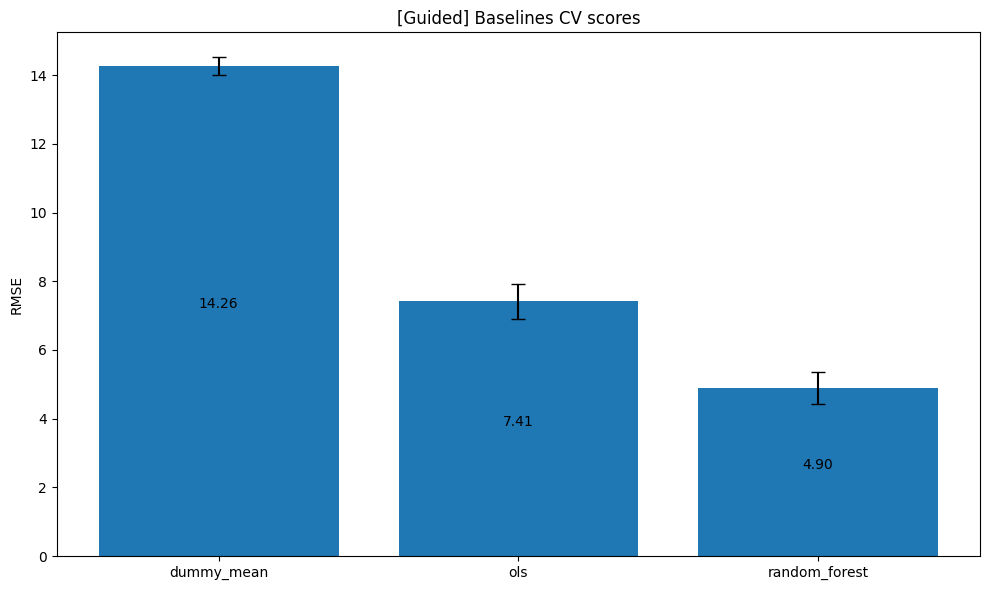

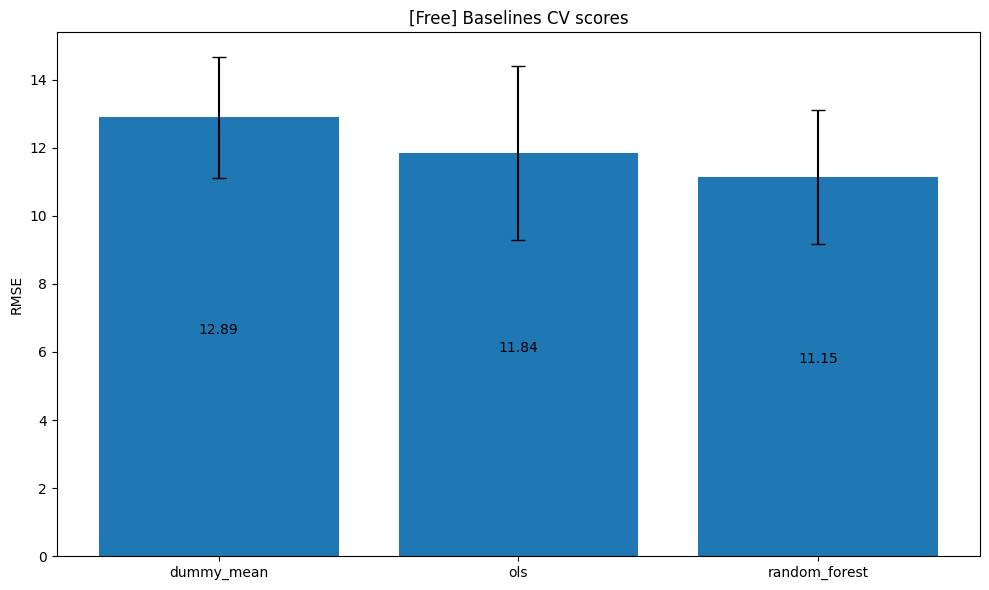

In [62]:
def plot_cv_results(cv_df, metric='rmse', title='CV RMSE Scores'):
    models = cv_df.index.tolist()
    scores = cv_df[f"{metric}"].values
    stds = cv_df[f"{metric}_std"].values

    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, scores , yerr=stds, capsize=5)
    plt.ylabel(metric.upper())
    plt.title(title)
    
    # score labels
    for bar, score in zip(bars, scores):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval/2, f'{score:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

plot_cv_results(baselines_cv_df_g, title="[Guided] Baselines CV scores")
plot_cv_results(baselines_cv_df_f, title="[Free] Baselines CV scores")


In [63]:
baselines_cv_df_g

,rmse,rmse_std,nmse,nmse_std
dummy_mean,14.259043,0.260633,0.437812,0.012145
ols,7.413334,0.520996,0.118876,0.016514
random_forest,4.903725,0.465373,0.052230,0.010243


In [64]:
baselines_cv_df_f

,rmse,rmse_std,nmse,nmse_std
dummy_mean,12.892779,1.769289,0.292550,0.024441
ols,11.840156,2.560903,0.245025,0.052083
random_forest,11.148180,1.961050,0.217467,0.028953


TODO: free move observations - guided random forest 0.05 nmse !! 95% of variance explained - task near optimal (noise left un explained)

__Observations__:

+ both models cut prediction error in half, this indicates that the dataset is relevant, meaning prediction/valuable information can be extracted from the features.

+ evidence of linear structure, linear regression explains ~75% of the dummy mean variance (NMSE reduced by ~75%).

+ additional non linear structure evidence, random forest further reduce prediction error (not as severe as from dummy to linear but still an early signal of 'structure')

(interesting to see jumps from dummy mean to linear to non linear, can help visualize/sense complexity/assumptions impact gradually)


In [65]:
# wont work with dummy mean no more
del baselines['dummy_mean']

#### 2) Feature importance

informative, to be used in feature selection, it must be done correctly avoiding leakage (see step 3 below).

__OLS__

```python
coef_ = [w_1_1, w_1_2, ..., w_1_48],  # weights of model 1
        ...
        [w_51_1, ..., w_51_48]        # weights of model 51
```
For interpretability and to get a general insight we aggregate the feature importances across all outputs by taking the mean (abs to avoid negative weights to cancel out).

(inspired by [external src](https://sourcebae.com/blog/how-to-get-coefficients-and-feature-importances-from-multioutputregressor/) and Tp5)

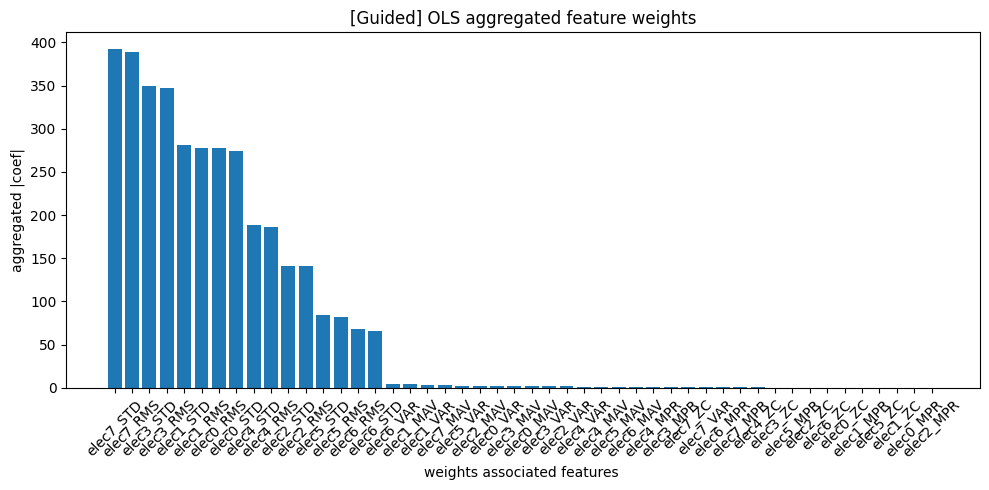

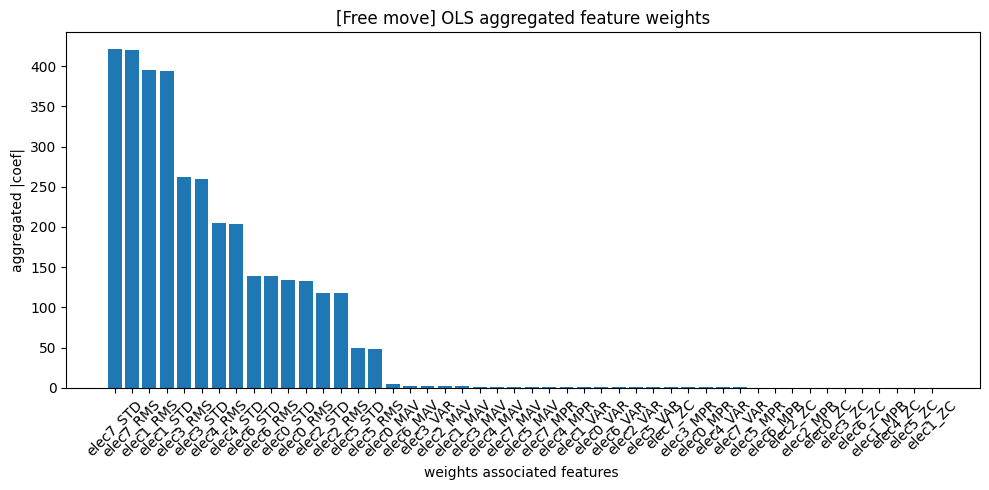

In [66]:
baseline_ols = make_pipeline(StandardScaler(), baselines['ols']) # add standardization for coefs interpretability
column_names = X_g_train_preproc.columns

def plot_ols_coefs(ols_reg, title:str):
    aggr_coef = np.mean(np.abs(ols_reg.coef_), axis=0) # average on columns
    ols_sorted_idx = np.argsort(aggr_coef)[::-1] # descending order

    plt.figure(figsize=(10, 5))
    plt.bar(range(len(aggr_coef)), aggr_coef[ols_sorted_idx], align='center')
    plt.xticks(range(len(aggr_coef)), column_names[ols_sorted_idx], rotation=45)
    plt.xlabel("weights associated features ")
    plt.ylabel("aggregated |coef|")
    plt.title(f"[{title}] OLS aggregated feature weights")
    plt.tight_layout()
    plt.show()

baseline_ols.fit(X_g_train_preproc, y_g_train_preproc)
plot_ols_coefs(baseline_ols[-1], "Guided")

baseline_ols.fit(X_f_train_preproc, y_f_train_preproc)
plot_ols_coefs(baseline_ols[-1], "Free move")


Observations: 

+ STD and RMS leading weights, other features nearly dropped, not considered. Coherence between guided and free moves
+ electrodes 2 and 3 dominant
+ hald the features are not considered/impactful, feature selection might be relevant

__Random forest__

We use the built in fitted 'features_importances_' attribute, but lets explain what exactly it represents, how is it calculated to interpret these scores at a deeper level than a simple ranking (might give deeper insights for next steps searhc direction).

For a feature j, each tree measures the total (sum) variance reduction (impurity) across all 51 outputs of every node splitting on j, summing the score for every such node in the tree, then, at forest level, this score is averaged over all tress to get the final importance score (then normalized)

Interpretation: how much on average splitting on that feature reduced impurity in the whole forest across all targets

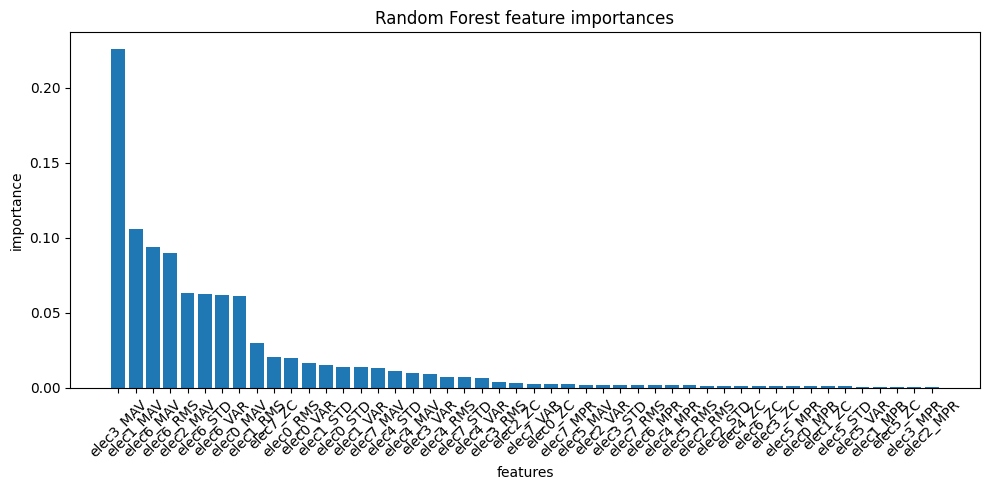

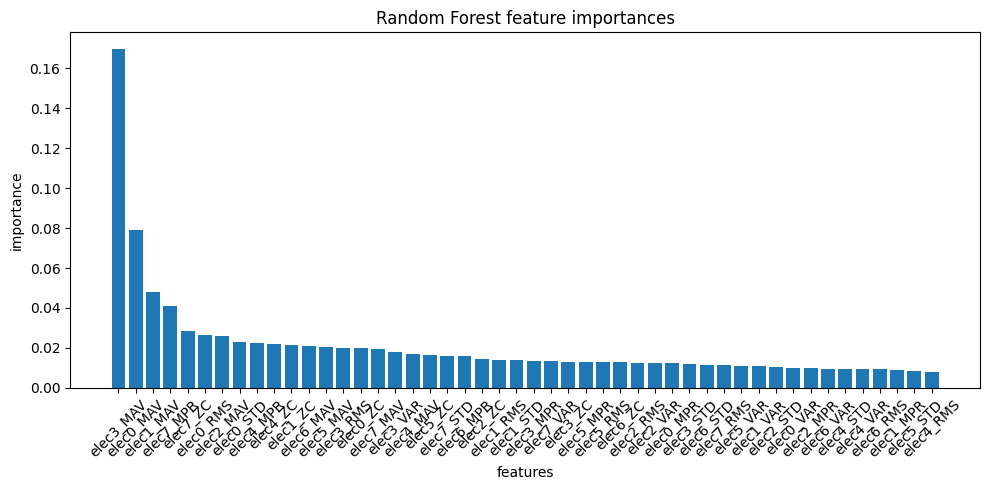

In [67]:
column_names = X_g_train_preproc.columns
baseline_rf = baselines['random_forest']

def plot_rf_feat_imp(rf_reg, title:str):
    feat_imp = rf_reg.feature_importances_
    sorted_idx = np.argsort(feat_imp)[::-1] # descending order

    plt.figure(figsize=(10, 5))
    plt.bar(range(len(feat_imp)), feat_imp[sorted_idx], align='center')
    plt.xticks(range(len(feat_imp)), column_names[sorted_idx], rotation=45)
    plt.xlabel("features")
    plt.ylabel("importance")
    plt.title("Random Forest feature importances")
    plt.tight_layout()
    plt.show()

baseline_rf.fit(X_g_train_preproc, y_g_train_preproc)
plot_rf_feat_imp(baseline_rf, "Guided")

baseline_rf.fit(X_f_train_preproc, y_f_train_preproc)
plot_rf_feat_imp(baseline_rf, "Guided")

Observations:
+  Guided and free move not overall coherant, but share elec3 mav high dependance

#### 3) Feature selection

We experiment feature selection on baseline models with 2 different feature selection strategies (filter and embedded) through a cross validated pipeline to avoid **data leakage**.

- If done separately (rank features before), features scores are computed using validation set information, so selection is done with data leakage.

**note**: We dont do hyper parametre tuning yet, the goal is to find the best (model + feature selection strategy) combination with default models. Even if hyperparametres logically can interact with feature selection, it is a trade off we accept (for the reasons explained above), if we had to handle it, it would be done with [nested cv](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html) to avoid leakage (tune and eval on same data).

(inspired from Tp5 and Tp3)

__PCA__

method by hand and pipeline + grid search were implemented, both result in same results, second method less prone to error (leak) and faster (gridsearch api optimized), so first one is here for justification and ensure results coherance both ways.

(We add a standardization step to every pipeline using PCA as it is scale sensitive, to avoid biased components)

In [68]:
"""
(do np.mean 5 times != 48)
cv_results = 
    [
        [fold1_1c, fold2_1c, ... fold5_1c],
        [fold1_2c, fold2_2c, ... fold5_2c],
        ...
        [fold1_48c, fold2_48c, ... fold5_48c],
    ]
"""

def pca_loop_feat_selec(model, X, y, groups):
    n_windows, n_features = X.shape
    CV_err = np.zeros((n_features, 5)) # (48, 5) TODO: avoid mgic number 5
    for fold, (train_index, test_index) in enumerate(logo.split(X, y, groups=groups)):
        X_tr, X_ts = X.iloc[train_index], X.iloc[test_index]
        y_tr, y_ts = y[train_index], y[test_index]
        
        # fold independant PCA - no leaking
        pca = PCA(random_state=0)
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)
        X_tr_pca = pca.fit_transform(X_tr_scaled)
        X_ts_scaled = scaler.transform(X_ts) # transform with fitted params on X_tr !
        X_ts_pca = pca.transform(X_ts_scaled) # transform with fitted params on X_tr !
        for k in range(n_features):
            model.fit(X_tr_pca[:, :k+1], y_tr) # train on k-best components
            y_hat = model.predict(X_ts_pca[:, :k+1])
            CV_err[k, fold] = rmse(y_hat, y_ts)

    best_n_components = 1
    best_cv_rmse = float('inf')
    for k in range(n_features):
        cv_rmse = np.mean(CV_err[k])
        if cv_rmse < best_cv_rmse:
            best_n_components = k+1 # (we worked with index nto with n_components)
            best_cv_rmse = cv_rmse
    
    return best_n_components, best_cv_rmse

def pca_grid_feat_selec(model, X, y, groups, scorer=rmse_scorer):
    pipe = make_pipeline(
        StandardScaler(),
        PCA(),
        model
    )

    n_windows, n_features = X.shape
    param_grid = {'pca__n_components': [i for i in range(1, n_features+1)]}

    grid = GridSearchCV(pipe, param_grid, cv=logo, scoring=scorer, n_jobs=-1)
    grid.fit(X, y, groups=groups)

    best_n_components = grid.best_params_['pca__n_components']
    best_cv_rmse = -grid.best_score_
    
    return best_n_components, best_cv_rmse

In [69]:
# Guided
print("Guided")
for name, model in baselines.items():
    best_n_components, best_cv_rmse = pca_grid_feat_selec(model, X_g_train_preproc, y_g_train_preproc, groups_g)
    # best_n_components, best_cv_rmse = pca_loop_feat_selec(model, X_g_train_preproc, y_g_train_preproc, groups_g)
    print(f"[{name}] Optimal #components = {best_n_components} with cv rmse = {best_cv_rmse}")

Guided
[ols] Optimal #components = 45 with cv rmse = 7.393577646947946
[random_forest] Optimal #components = 9 with cv rmse = 5.83339649452482


In [70]:
# Free
print("Free")
for name, model in baselines.items():
    best_n_components, best_cv_rmse = pca_grid_feat_selec(model, X_f_train_preproc, y_f_train_preproc, groups_f)
    # best_n_components, best_cv_rmse = pca_loop_feat_selec(model, X_g_train_preproc, y_g_train_preproc, groups_g)
    print(f"[{name}] Optimal #components = {best_n_components} with cv rmse = {best_cv_rmse}")

Free
[ols] Optimal #components = 22 with cv rmse = 11.635252346223112
[random_forest] Optimal #components = 33 with cv rmse = 11.381562308571953


Observations: 

for random forest, this method doesnt outperform raw model as the scaling step might weaken previously clear / obvious splits. We get improvements without the scalign step but still less then next method and not 'guideline' (PCA requires scaling so if it underperforms then PCA shoudlnt be used with tree based models)

__Embedded__

We set threshold=0 to have 'pure' feature selection, otherwise some features get discarded as the default threshold uses a mean strategy.

We use same model for pipeline final estimator and embedded feature importances estimator by convention (could try all 4 combinations) as both models have native feature importances (coefs_, feature_importances_) and thus are supported by SelectFromModel.

In [26]:
def embeded_grid_feat_selec(model, X, y, groups, scorer=rmse_scorer):
    pipe = Pipeline([
        ('select', SelectFromModel(model, threshold=0)),
        ('model', model)
    ])
    
    n_windows, n_features = X.shape
    # param_grid = {'selectfrommodel__max_features': [i for i in range(1, n_features+1)]}
    param_grid = {'select__max_features': [i for i in range(1, n_features+1)]}

    grid = GridSearchCV(pipe, param_grid, cv=logo, scoring=scorer, n_jobs=-1)
    grid.fit(X, y, groups=groups)

    best_n_features = grid.best_params_['select__max_features']
    best_cv_rmse = -grid.best_score_
    
    return best_n_features, best_cv_rmse

In [27]:
print("Guided")
for name, model in baselines.items():
    best_n_features, best_cv_rmse = embeded_grid_feat_selec(model, X_g_train_preproc, y_g_train_preproc, groups_g)
    
    print(f"[{name}] Optimal #features = {best_n_features} with cv rmse = {best_cv_rmse}")

Guided
[ols] Optimal #features = 48 with cv rmse = 7.248052301286036
[random_forest] Optimal #features = 34 with cv rmse = 4.960515907891919


In [28]:
print("Free")
for name, model in baselines.items():
    best_n_features, best_cv_rmse = embeded_grid_feat_selec(model, X_f_train_preproc, y_f_train_preproc, groups_f)
    
    print(f"[{name}] Optimal #features = {best_n_features} with cv rmse = {best_cv_rmse}")

Free
[ols] Optimal #features = 45 with cv rmse = 11.264842863405722
[random_forest] Optimal #features = 27 with cv rmse = 10.999034037754729


#### 4) Final baseline

Select as final baseline, the best performing [feature selection + baseline model] combination explored (infinite possibilities).

In [29]:
final_baseline_pipe_g = make_pipeline(
    FeatureExtractor(),
    SelectFromModel(baselines['random_forest'], threshold=0, max_features=34),
    baselines['random_forest']
)

final_baseline_pipe_f = make_pipeline(
    FeatureExtractor(),
    StandardScaler(),
    PCA(n_components=38),
    baselines['random_forest']
)

In [ ]:
# # Guided
# best_baseline_pipe.fit(X_g_train_wdw, y_g_train_preproc) # train on windowed data since pipeline must contain Feature extractor to predict not preprocessed X_g_test, since X_g_train_preproc already preprocessed 
# guided_predictions = best_baseline_pipe.predict(X_g_test)
# print(guided_predictions.shape)

# # Freemove
# X_f_train_wdw = XWindowAugment().transform(X_f_train)
# y_f_train_wdw = yWindowAugment().transform(y_f_train)
# y_f_train_preproc = TargetFlattener().transform(y_f_train_wdw)

# best_baseline_pipe.fit(X_f_train_wdw, y_f_train_preproc)
# freemoves_predictions = best_baseline_pipe.predict(X_f_test)
# print(freemoves_predictions.shape)

# # baseline prediction file
# baseline_predictions = np.vstack((guided_predictions, freemoves_predictions))
# print(f"final pred array shape {baseline_predictions.shape}")

# baseline_predictions_df = pd.DataFrame(baseline_predictions)
# baseline_predictions_df.to_csv(f'{pred_dir}/baseline_predictions.csv', index=False)

(1660, 51)
(1540, 51)
final pred array shape (3200, 51)


___

## More complex approaches

### Covariance matrix

TODO: better overview
High level overview:
+ Estimate the covariance matrix (between the 8 electrodes - $C_{8\times8}$) for each sample (window), use OAS shrinkage for regularization (regularization benefits).
+ Map each one to a vector $v \in R^{m(m+1)/2}$ in the space tangent at the train set Riemann mean (geometric mean of all training set covariance matrices) 


__Intuition/Motivation__: this method is a good fit/idea for this task and might have been proposed with domain knowledge since we know that forearm electrodes picking up muscle activity can and should be correlated (their signals) since the hand movement (pose) is a complex mechanism relying on multiple muscle (electrodes), so we know they interact and are correlated. This method tries to capture such "spatial" correlation between the electrodes through a (1 per windw) covariance matrix. 


In [38]:
class XWindowSampleReshaper(BaseEstimator, TransformerMixin):
    """
    Reshape each window as a sample

    (sessions, windows, ...) --> (sessions*windows, ...)
    """

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        n_sessions, n_windows, n_electrodes, n_times = X.shape
        X_sample = X.reshape(n_sessions*n_windows, n_electrodes, n_times)
        return X_sample

Expected __input shape__ (as described in pyRiemann github): 

+ X (n_epochs x n_channels x n_times)
+ y (n_epochs x n_output)

Since it needs the raw signals associated to each window to compute (estimate) the covariance matrix between channels (electrodes). \
So X should be reshaped accordingly and preprocessed y already in correct shape (only need labels associated to each of these windows)

In [39]:
# Guided
X_g_train_sample = XWindowSampleReshaper().transform(X_g_train_wdw)
print(f"X_g_train_sample{X_g_train_sample.shape}")
# Free
X_f_train_sample = XWindowSampleReshaper().transform(X_f_train_wdw)
print(f"X_f_train_sample{X_f_train_sample.shape}")

X_g_train_sample(4595, 8, 500)
X_f_train_sample(5395, 8, 500)


In [51]:
cov_mat_pipe = make_pipeline(
    Covariances(estimator='oas'),
    TangentSpace(), # defult metric = riemann
    StandardScaler(),
    Lasso() # default support multioutput
)

# Guided
cov_mat_g_cv_res = _logo_cv(X_g_train_sample, y_g_train_preproc, cov_mat_pipe, groups_g)
print(f"[Guided] rmse = {cov_mat_g_cv_res[0]} / nmse = {cov_mat_g_cv_res[1]}")

# Free
cov_mat_f_cv_res = _logo_cv(X_f_train_sample, y_f_train_preproc, cov_mat_pipe, groups_f)
print(f"[Free] rmse = {cov_mat_f_cv_res[0]} / nmse = {cov_mat_f_cv_res[1]}")



/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


[Guided] rmse = 7.7165923062517425 / nmse = 0.12857383071665943
[Free] rmse = 10.723607441098014 / nmse = 0.2034010844756935


Observations:

+ For Guided dataset, not outperforming ~4.96 rmse from best baseline (random forest with embedded feature selection)

This can be explained by the fact that the guided dataset is a simpler task (simpler one finger guided gestures), so the baseline random forest with common time domain features is able to capture most of the predictable variance, so the covariances matrices may not add much more "prediction power" than the simpler statistics (common time domain features) used in the baseline.\
We also remember that the baseline random forest was at 5% nmse which meant the task was nearly fully explained (if we assume only noise left), now nmse scores are 2x higher.

+ For Free dataset, outperforming ~10.989 rmse from best baseline (random forest with pca feature selection)

In contrast, the free move dataset is much more complex with simultaneous muscle/sensors interactions that the simpler statistics used in baseline may not fully capture, and a covariance matrix is a way better "tool" to express such complex interactions. \
Another interesting point is that we know that this task is more prone to noise, and the covariance pipeline uses regularization through OAS estimation, making it more robust to noise.


### Neural Network

For the neural network approch, we have done:

##### Simple model
We started by a simple model composed of 3 linear layers.

At first, for training our model we were going to use the exact same training loop as in Lab 4, but after some research, we discovered that wrapping our PyTorch module with [Skorch](https://skorch.readthedocs.io/en/stable/) offered more advantages : compatibility with sklearn, reuse our existing cv_logo() function, concise maintainable code.


The rmse mean was 17.03, which beat the vanilla lasso model but not the covriance matrices lasso. We analyzed the value of the training loss and validation loss for each epoch and we saw that the model is underfitting.
So we decide to complexify it.

##### Model complexity

We upgraded to a small CNN with three 1D convolutional layers because the dataset has to much datas for an nn classique and to automatically learn local temporal patterns in the EMG signal. 

After each convolutional layer:

We normalize our data to stabilize and speed up training.

We introduce a simple Relu activation so the network can learn more complex features.

We “cut” the time dimension in half, keeping only the strongest responses and reducing data size.

Once the three convolutional blocks are done, we flatten the output tensor and pass it into a two layer head, to convert these extracted features into the 51 joint-angle predictions

##### Early stopping and LR scheduling

We added two Skorch callbacks:

-EarlyStopping to stop the training when no improvement is seen for 10 epochs.

-LRScheduler to cut the learning rate by half when the validation loss stalls 3 epochs consecutives.

This combination prevents wasted epochs once the model converges and refines the learning rate to squeeze out extra gains.

##### Batch size reduction

We lowered the batch size from 128 to 64. Using smaller batches adds a bit of randomness to each weight update, which helps the model generalize better without altering its structure.

With these three changes, the nn average RMSE dropped to ~4,70, a dramatic improvement over the initial ~17.

| Simple Model | Complex Model | Complex Model + Early Stopping & LR Scheduler | Same as #3 but Batch Size = 64 |
|:------------:|:-------------:|:---------------------------------------------:|:-----------------------------:|
| ![](./images/1.png) | ![](./images/2.png) | ![](./images/3.png) | ![](./images/4.png) |
| **RMSE mean:** 17.03 | **RMSE mean:** 6.06 | **RMSE mean:** 5.89 | **RMSE mean:** 4.70 |


Data Preparation



In [32]:
x_shape_f = X_f_train_wdw.shape

X_g_train_wdw_cnn = X_g_train_wdw.reshape(x_shape[0]* x_shape[1], x_shape[2] * x_shape[3])
X_f_train_wdw_cnn = X_f_train_wdw.reshape(x_shape_f[0]* x_shape_f[1], x_shape_f[2] * x_shape_f[3])

# Convert dataset from float64 to float32 because PyTorch layers expect float32
# 32-bit precision is sufficient for our signals and speeds up training
print(X_g_train_wdw_flat.dtype)   
print(y_g_train_preproc.dtype)   

x_g_cnn = X_g_train_wdw_cnn.astype('float32')
y_g_torch = y_g_train_preproc.astype('float32')

x_f_cnn = X_f_train_wdw_cnn.astype('float32')
y_f_torch = y_f_train_preproc.astype('float32')

float64
float64


In [ ]:
## NN method

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.f = nn.Sequential(
            nn.Unflatten(1, (8,500)), #unflatten data for  convolution (64 (batch_size), 8,500)

            nn.Conv1d(8, 32, kernel_size=11, padding=5), # 8 input channels (electrodes) and 32 is the output, the number of feature he learn.
            # Thanks to padding, the output length remains 500 (64,32,500) 
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),  # Halve the temporal dimension  (64,32,250)          
            
            nn.Conv1d(32, 64, kernel_size=9, padding=4), #(64,64,250)
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),  #(64,64,125)      

            nn.Conv1d(64, 128, kernel_size=7, padding=3), # (64,128,125)
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),  # (64,128,62)    
            
            nn.Flatten(), # Reflatten our data for the next part (64,128*62)
        )
        self.r = nn.Sequential(
            nn.Linear(7936, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 51),
        )

    def forward(self, x):
        x = self.f(x)
        return self.r(x)

      

net = NeuralNetRegressor(
    module=NeuralNetwork,                 # PyTorch model 
    max_epochs=100,                 
    lr=1e-3,                       
    batch_size=64,
    optimizer=torch.optim.Adam,
    callbacks=[('earlystop', EarlyStopping('valid_loss', patience=10)), # Stop if validation loss doesn't improve for 10 epochs 
                    ('lr_sched', LRScheduler(
           policy=torch.optim.lr_scheduler.ReduceLROnPlateau, # Halve LR if validation loss stalls for 3 epochs
           monitor='valid_loss',
           patience=3, factor=0.5))]
)


pipe_cnn = Pipeline([
    ('scale', StandardScaler()),  # Standardize inputs for a quick start, after the cnn will then normalize its data at each step
    ('net',   net)                
])

In [48]:
#Guided 
logo_cv(x_g_cnn,y_g_torch,pipe_cnn,groups_g)

/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/skorch/net.py:2261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/khal

  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      229.9213      117.9700  0.0010  14.9532
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      218.6708      139.9417  0.0010  15.0134
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      230.2671      123.7041  0.0010  15.0174
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      218.6525      143.9246  0.0010  15.1273
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      230.3056      122.7271  0.0010  15.1759
      2      114.0537       75.0517  0.0010  13.6623
      2      124.3599      130.6656  0.0010  13.8752
      2      118.6774       86.9163  0.0010  13.8384
      2      122.7602       93.8567  0.0010  1

np.float64(4.843506526947022)

In [70]:
#Free 
logo_cv(x_f_cnn,y_f_torch,pipe_cnn,groups_f)

/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/skorch/net.py:2261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/khal

  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      219.7845      257.3497  0.0010  17.6455
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      202.5176      216.7474  0.0010  17.6848
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      232.3706      159.4028  0.0010  18.6981
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      214.8950      229.9182  0.0010  18.8064
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      224.2463      190.0896  0.0010  18.8602
      2      148.4243      149.9654  0.0010  18.7274
      2      154.3617      247.8510  0.0010  18.7459
      2      166.5656      140.9631  0.0010  18.8178
      2      161.9727      159.0431  0.0010  1

np.float64(11.681501770019532)

Stopping since valid_loss has not improved in the last 10 epochs.


Observations with the CNN

+ For Guided dataset, outperforming ~(4.70  vs 4.96) rmse from best baseline (random forest with embedded feature selection):

The CNN outperforms both the RF baseline and the covariance pipeline. Its stacked convolutions and pooling stages excel at modeling the repetitive, localized temporal features inherent to the guided gestures.

+ For Free dataset, not outperforming ~ (11.68. vs 10.72) rmse from the covariance pipeline:
 
By contrast, the CNN does worse than the covariance method. Free gestures are very varied and noisy, different electrodes fire together in complicated ways. The covariance pipeline directly summarizes how each pair of sensors varies together  and uses OAS shrinkage to keep those estimates stable even with few samples. The CNN, however, has to learn all of that from the raw signals and can’t do it reliably when the data are noisy and limited.

### Neural Network Hybrid

Although the CNN achieved lower mean RMSE than the covariance pipeline on the guided set, its training time was longer. To combine the CNN accuracy with the covariance approach speed, I built a hybrid version, after computing OAS regularized covariance matrices and projecting them into tangent space, I replaced the heavy CNN with a lightweight, two-layer neural network. This hybrid comes close to the CNN performance on the guided dataset, still outperforms CNN on the free set, and trains and runs in a fraction of the time.

Compared to the original covariance pipeline, it delivers a lower average RMSE, which should translate into stronger results when we incorporate it, latter, into our ensembling strategies.

In [44]:
from sklearn.preprocessing import FunctionTransformer

#Small nn
class Cov_nn(nn.Module):
    def __init__(self):
        super().__init__()
        self.s = nn.Sequential(
          nn.Linear(36, 128),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(128, 64),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(64, 51)
        )

    def forward(self, x):
        return self.s(x)

net_nn2 = NeuralNetRegressor(
    module      = Cov_nn,
    max_epochs  = 200,
    lr          = 1e-3,
    batch_size  = 64,
    optimizer   = torch.optim.Adam,
    callbacks=[('earlystop', EarlyStopping('valid_loss', patience=10)), # Stop if validation loss doesn't improve for 5 epochs 
                    ('lr_sched', LRScheduler(
           policy=torch.optim.lr_scheduler.ReduceLROnPlateau, # Halve LR if validation loss stalls for 3 epochs
           monitor='valid_loss',
           patience=3, factor=0.5))]
)


pipe_fusion = Pipeline([
    ('cov',   Covariances(estimator='oas')),   
    ('ts',    TangentSpace()),                
    ('scale', StandardScaler()),               
    ('cast',  FunctionTransformer(lambda X: X.astype(np.float32), validate=False)), # cast to float32 for PyTorch compatibility
    ('nn',   net_nn2)                          
])


In [72]:
#Guided
logo_cv(X_g_train_sample,y_g_torch,pipe_fusion,groups_g)

/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/skorch/net.py:2261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/khal

Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      469.7012      399.1528  0.0010  0.1394
Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      465.9198      392.7451  0.0010  0.1479
Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      470.6780      407.5156  0.0010  0.1407
      2      298.0799      186.3305  0.0010  0.1519
      2      288.3443      180.6989  0.0010  0.1677
      2      296.9497      190.1787  0.0010  0.1875
      3      185.6084      139.4098  0.0010  0.1902
      3      179.0327      138.8436  0.0010  0.1813
      3      181.0977      139.1735  0.0010  0.1807
      4      152.4735 

np.float64(5.314470386505127)

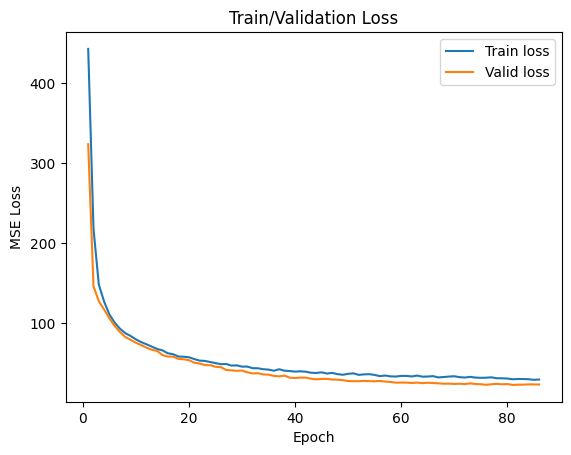

In [73]:
#Free 
logo_cv(X_f_train_sample,y_f_torch,pipe_fusion,groups_f)

/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/skorch/net.py:2261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/khal

Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      694.7936      448.1151  0.0010  0.1062
Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      684.0408      470.0561  0.0010  0.1351
      2      367.2370      182.0368  0.0010  0.1193
      2      390.0210      189.4545  0.0010  0.1089
      3      194.8222      143.1938  0.0010  0.1219
      3      195.5096      152.3147  0.0010  0.1360
      4      172.5560      134.1952  0.0010  0.1578
      4      171.4561      141.5842  0.0010  0.1512
      5      168.8095      130.9939  0.0010  0.1663
      5      162.9923      136.7340  0.0010  0.2157
      6      163.5861      128.3901  0.0010  0.2076
      6      158.8502      133.3928  0.0010  0.1690
      7      159.5671      126.4567 

np.float64(10.593882751464843)

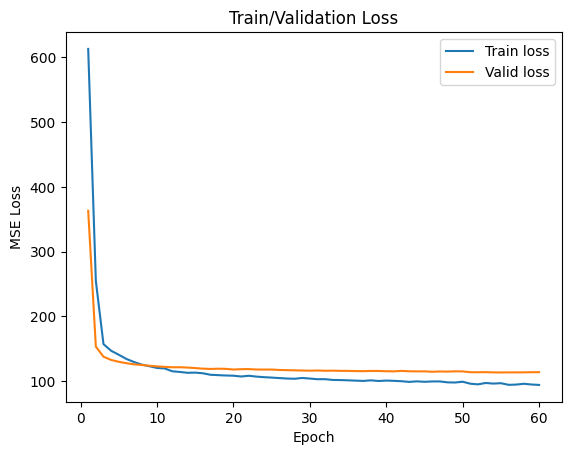

  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      438.1266      317.3583  0.0010  0.2392
      2      210.7841      147.1218  0.0010  0.1064
      3      148.5364      129.5678  0.0010  0.1145
      4      128.1991      116.6018  0.0010  0.1087
      5      112.6288      103.3852  0.0010  0.1833
      6       98.7212       93.4133  0.0010  0.1131
      7       91.1136       85.1166  0.0010  0.1124
      8       86.7346       79.9718  0.0010  0.1107
      9       82.6419       76.2744  0.0010  0.1031
     10       77.6831       72.5320  0.0010  0.1012
     11       74.1289       69.0363  0.0010  0.1120
     12       70.2340       66.2016  0.0010  0.1082
     13       66.9896       62.9956  0.0010  0.1220
     14       64.4808       60.1130  0.0010  0.1200
     15       61.2709       57.9670  0.0010  0.1118
     16       61.5594       55.7855  0.0010  0.1210
     17       57.0717       53.7318  0.0010  0.1052
     18     

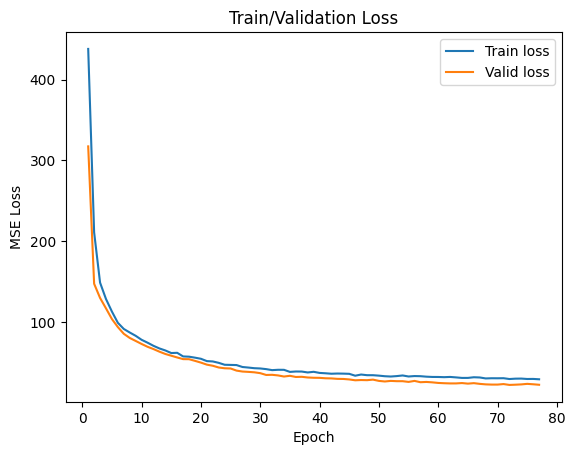

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      631.9446      408.2830  0.0010  0.2137
      2      287.1050      166.4673  0.0010  0.1717
      3      159.3194      142.8032  0.0010  0.1702
      4      147.1170      136.3799  0.0010  0.2314
      5      139.1102      132.9987  0.0010  0.2831
      6      133.9552      128.9599  0.0010  0.2691
      7      128.8431      127.7616  0.0010  0.2998
      8      125.3314      126.5722  0.0010  0.3010
      9      124.3235      125.2900  0.0010  0.1829
     10      121.5972      123.0820  0.0010  0.1559
     11      118.3741      122.5123  0.0010  0.1468
     12      116.7954      121.9616  0.0010  0.1551
     13      115.1416      121.6828  0.0010  0.1520
     14      113.5667      121.2988  0.0010  0.1594
     15      113.8444      120.2085  0.0010  0.1721
     16      112.9347      119.2975  0

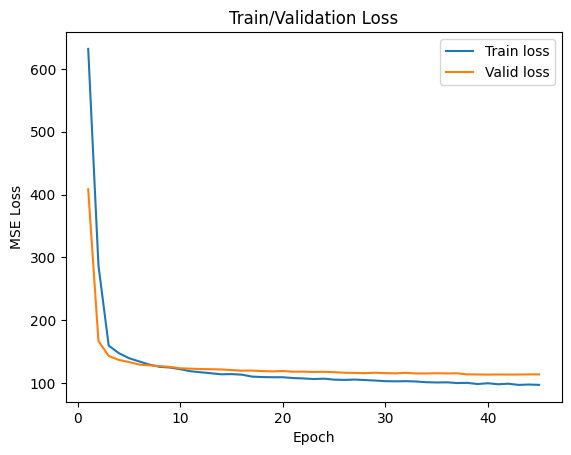

In [57]:
import matplotlib.pyplot as plt



def plot(pipeline):
    history = pipeline.named_steps['nn'].history
    
    epochs = history[:, 'epoch']
    train_loss = history[:, 'train_loss']
    valid_loss = history[:, 'valid_loss']
    
    plt.plot(epochs, train_loss, label='Train loss')
    plt.plot(epochs, valid_loss, label='Valid loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Train/Validation Loss')
    plt.legend()
    plt.show()

pipe_fusion.fit(X_g_train_sample, y_g_torch)
plot(pipe_fusion)
pipe_fusion.fit(X_f_train_sample, y_f_torch)
plot(pipe_fusion)

| Method                                   | RMSE Guided | RMSE  Free |
|------------------------------------------|-------------------|------------------:|
| Basic Lasso                              |      18.73 | 15.78 |
| Random Forest with Guided = Embedded and Free = PCA    |   4.96 |10.98 |
| Covariance matrices + Lasso              |       7.71 | 10.72 |
| Covariance matrices + Neural Network     |       5.08 | 10.56|
| Convolutional Neural Network             |       4.70 | 11.68|

## Ensembling strategies






For this question, we have 3 regression models trained on different feature representations:

- ...
- Tangentes spaces of the signal using the NN + Covariance Matrice
- Filtered raw signal data using a CNN


To obtain each models predictions, we use cross_val_predict, which is essentially the same as cross_val_score but returns the predictions of each fold instead of the scores.

In [74]:
# I needed to make a small change for the pipeline of the basic approch, "cross_val_predict" want x and y to be 2d tab, so before using the function 
# i already use the FeatureExtractor()

final_baseline_pipe_g_predict = make_pipeline(
    SelectFromModel(baselines['random_forest'], threshold=0, max_features=34),
    baselines['random_forest']
)

final_baseline_pipe_f_predict = make_pipeline(
    StandardScaler(),
    PCA(n_components=38),
    baselines['random_forest']
)

In [97]:
# Prediction of each model for the guided and free dataset 


y_g_predict_rf = cross_val_predict(final_baseline_pipe_g_predict, X_g_train_preproc, y_g_train_preproc, groups=groups_g, cv=logo, n_jobs=-1) 
y_f_predict_rf = cross_val_predict(final_baseline_pipe_f_predict, X_f_train_preproc, y_f_train_preproc, groups=groups_f, cv=logo, n_jobs=-1)

y_g_predict_cnn = cross_val_predict(pipe_cnn,x_g_cnn, y_g_torch, groups=groups_g, cv=logo, n_jobs=-1)
y_f_predict_cnn = cross_val_predict(pipe_cnn,x_f_cnn, y_f_torch, groups=groups_f, cv=logo, n_jobs=-1)

y_g_predict_nn_covariance = cross_val_predict(pipe_fusion, X_g_train_sample, y_g_torch, groups=groups_g, cv=logo, n_jobs=-1)
y_f_predict_nn_covariance = cross_val_predict(pipe_fusion, X_f_train_sample, y_f_torch, groups=groups_f, cv=logo, n_jobs=-1)


y_g_predict_ensemble = (y_g_predict_cnn + y_g_predict_nn_covariance + y_g_predict_rf) / 3 
y_f_predict_ensemble = (y_f_predict_cnn + y_f_predict_nn_covariance + y_f_predict_rf) / 3 


/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/skorch/net.py:2261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/khal

  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      186.0317      111.3252  0.0010  12.5740
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      187.2693      117.2134  0.0010  12.5928
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      187.9613      112.6932  0.0010  12.7004
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      192.5413      117.5867  0.0010  12.7498
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      192.5431      116.7889  0.0010  12.7722
      2       84.8149      128.2489  0.0010  12.4072
      2       83.0726       92.9731  0.0010  12.5465
      2       87.9794       76.7991  0.0010  12.4822
      2       86.8622       70.6496  0.0010  1

/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/skorch/net.py:2261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals

  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      220.7676      273.2072  0.0010  18.9884
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      236.2817      153.7239  0.0010  18.9493
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      223.4266      182.5094  0.0010  18.9633
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      222.2463      219.8944  0.0010  19.0867
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      203.2047      227.9484  0.0010  19.1648
      2      154.2994      264.2821  0.0010  18.1586
      2      158.7720      170.6860  0.0010  17.8543
      2      166.2864      138.8067  0.0010  17.9602
      2      171.5344      210.0437  0.0010  1

/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/skorch/net.py:2261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/khal

Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      466.9742      398.7365  0.0010  0.2009
Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      472.3203      403.7773  0.0010  0.2186
Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      458.9331      387.5907  0.0010  0.2215
      2      281.5375      180.9925  0.0010  0.1879
      2      287.7370      182.1694  0.0010  0.1455
      2      265.9309      174.3124  0.0010  0.1718
      3      172.4753      137.7930  0.0010  0.1638
      3      166.1689      136.8466  0.0010  0.1712
      3      163.4498      139.8031  0.0010  0.2480
      4      143.1749 

/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/skorch/net.py:2261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/khal

Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      678.8547      454.5693  0.0010  0.2876
Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      692.3788      437.5096  0.0010  0.2894
      2      368.2296      193.0999  0.0010  0.4065
      2      347.0674      170.9380  0.0010  0.3361
      3      176.2114      153.7313  0.0010  0.2973
      3      180.1717      141.3006  0.0010  0.2806
      4      155.8423      143.9189  0.0010  0.2870
      4      163.9041      132.4017  0.0010  0.2941
      5      148.6395      137.9872  0.0010  0.3606
      5      153.0856      127.7651  0.0010  0.3431
      6      147.5773      124.5009  0.0010  0.2421
      6      142.5300      135.0160  0.0010  0.2454
      7      138.0885      131.7883 

In [98]:
def calculate_metrics(y,y_predict):
    mse  = mean_squared_error(y, y_predict)
    rmse = np.sqrt(mse)
    nmse = mse / np.var(y)  
    return rmse, nmse 



# Metrics Guided
rmse_g_rf,   nmse_g_rf   = calculate_metrics(y_g_train_preproc, y_g_predict_rf)
rmse_g_cnn,   nmse_g_cnn   = calculate_metrics(y_g_train_preproc, y_g_predict_cnn)
rmse_g_nn,    nmse_g_nn    = calculate_metrics(y_g_train_preproc, y_g_predict_nn_covariance)
rmse_g_ens,   nmse_g_ens   = calculate_metrics(y_g_train_preproc, y_g_predict_ensemble)


# RMSE Free
rmse_f_rf,   nmse_f_rf   = calculate_metrics(y_f_train_preproc, y_f_predict_rf)
rmse_f_cnn,   nmse_f_cnn   = calculate_metrics(y_f_train_preproc, y_f_predict_cnn)
rmse_f_nn,    nmse_f_nn    = calculate_metrics(y_f_train_preproc, y_f_predict_nn_covariance)
rmse_f_ens,   nmse_f_ens   = calculate_metrics(y_f_train_preproc, y_f_predict_ensemble)



print(f"Random Forest  | RMSE | guided: {rmse_g_rf:.2f} | free: {rmse_f_rf:.2f} | NSME | guided: {nmse_g_rf:.2f} | free: {nmse_f_rf:.2f} ")

print(f"NN + Covariance  | RMSE | guided: {rmse_g_nn:.2f} | free: {rmse_f_nn:.2f} | NMSE | guided: {nmse_g_nn:.2f} | free: {nmse_f_nn:.2f}")

print(f"CNN  | RMSE | guided: {rmse_g_cnn:.2f} | free: {rmse_f_cnn:.2f} | NMSE | guided: {nmse_g_cnn:.2f} | free: {nmse_f_cnn:.2f}")

print(f"Ensemble average | RMSE | guided: {rmse_g_ens:.2f} | free: {rmse_f_ens:.2f}  | NMSE | guided: {nmse_g_ens:.2f} | free: {nmse_f_ens:.2f}")

Random Forest  | RMSE | guided: 4.99 | free: 11.11 | NSME | guided: 0.05 | free: 0.21 
NN + Covariance  | RMSE | guided: 5.11 | free: 10.59 | NMSE | guided: 0.06 | free: 0.19
CNN  | RMSE | guided: 4.64 | free: 12.28 | NMSE | guided: 0.05 | free: 0.26
Ensemble average | RMSE | guided: 4.22 | free: 10.52  | NMSE | guided: 0.04 | free: 0.19


At this point we have our ensemble predictions (y_ensemble) and all the metrics we need for the average method. The power of this approach depends not only on each models individual performance but also on the diversity of their errors. Because we weight every model equally, a very weak model can drag the average down.

However, when all the models are accurate enough and make different kinds of mistakes, averaging becomes extremely effective. For example, our CNN excels at learning local, spatial patterns in the raw signal, while our nn + covariance network captures global statistical dependencies over time. Their errors rarely coincide, so when the CNN prediction is off for a given sample, the nn model often compensates it, and vice-versa. By averaging their outputs, we reduce the total variance and achieve a lower rmse/nmse than either model on its own, all without any extra hyperparameter tuning


### Stacking

For the second method, we concatenate the predictions of our models into a new dataset. This dataset will have the form (n_windows, targets × M), with M being the number of different models. After that, we train our model on this data and calculate the RMSE compared to the true y.

In [108]:
# Creation of the new dataset with the prediction of our models 
x_g_meta = np.concatenate([y_g_predict_cnn, y_g_predict_nn_covariance,y_g_predict_rf], axis=1)
x_f_meta = np.concatenate([y_f_predict_cnn, y_f_predict_nn_covariance,y_f_predict_rf], axis=1) 

# model 
lasso_model = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso',  Lasso(alpha=0.1, max_iter=20000))
    ])

# Calculate the prediction
y_g_predict_stack = cross_val_predict(lasso_model,x_g_meta,y_g_train_preproc,groups=groups_g,cv=logo,n_jobs=-1)
y_f_predict_stack = cross_val_predict(lasso_model,x_f_meta,y_f_train_preproc,groups=groups_f,cv=logo,n_jobs=-1)


#Calculate the metrics 
rmse_g_stack, nmse_g_stack = calculate_metrics(y_g_train_preproc, y_g_predict_stack)
rmse_f_stack, nmse_f_stack = calculate_metrics(y_f_train_preproc, y_f_predict_stack)

print(f"Ensemble stacking | RMSE | guided: {rmse_g_stack:.2f} | free: {rmse_f_stack:.2f}  | NMSE | guided: {nmse_g_stack:.2f} | free: {nmse_f_stack:.2f}")

/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Ensemble stacking | RMSE | guided: 4.57 | free: 10.96  | NMSE | guided: 0.04 | free: 0.21


| Model / Ensembling       | RMSE Guided       | NMSE Guided       | RMSE Free         | NMSE Free         |
| ---------------------- | ----------------- | ----------------- | ----------------- | ----------------- |
| Random Forest with Guided = Embedded and Free = PCA    |   4.99 | 0.05|11.11 | 0.21|
| Covariance matrices + Neural Network   | 5.13      | 0.06      | 10.66      | 0.20      |
| CNN | 4.80   |  0.05  | 11.66   | 0.24   |
| Averaging   | 4.31 | 0.04 | 10.43 | 0.19 |
| Stacking    | 4.44    | 0.04    | 11.86    | 0.21    |




### Contributions of each model:

In [ ]:
# Train the model with all the dataset 
lasso_model.fit(x_g_meta,y_g_train_preproc)


# Have the coefficient for each output compare to each input
# the matrix will have the shape (51, 51 * m)
coeff_matrice = lasso_model.named_steps['lasso'].coef_

def model_contributions(coeff_matrice,model_names):
    m = len(model_names) 
    n_outputs, n_features = coeff_matrice.shape
    per_model = n_features // m
    
    coef_abs = np.abs(coeff_matrice)
    
    # Calculate the coeef for each model and put them in a dico 
    sums = {}
    for i in range(m):
        start = i * per_model
        end   = (i + 1) * per_model
        model_sum = coef_abs[:, start:end].sum()
        sums[model_names[i]] = model_sum
    
    # Normalize so that the contributions sum to 1
    total = sum(sums.values())
    for name in sums:
        sums[name] /= total
        
    return sums

models_names = ["CNN","NN + Covariance","Random Forest Embedded"]
sums_g = model_contributions(coeff_matrice, models_names)

#free 
lasso_model.fit(x_f_meta,y_f_train_preproc)
coeff_matrice_f = lasso_model.named_steps['lasso'].coef_
models_names = ["CNN","NN + Covariance","Random Forest PCA"]
sums_f = model_contributions(coeff_matrice_f, models_names)

In [ ]:
def plot_contibutions(sums,dataset_name):
    models = list(sums.keys())
    contribs = list(sums.values())
    
    plt.figure()
    plt.bar(models, contribs)
    plt.ylabel('Relative Contribution')
    plt.xlabel('Base Model')
    plt.title('Model Contributions in Meta-Learner ' + dataset_name)
    plt.tight_layout()
    plt.show()

plot_contibutions(sums_g,"Guided")
plot_contibutions(sums_f,"Free")

When we inspect the Lasso meta-learner coefficients, we see that it relies most heavily on the CNN predictions for the guided dataset, and on the covariance + NN model for the free dataset. This makes perfect sense given each model’s strengths. The stacking model has automatically selected the model that is best suited to each task.

# à completer 
"Discuss how the bias-variance tradeoff relates to the observed (or expected)
evolution of performance."

### Question 7

In [75]:
def predict(model, x_train, y_train, test_x):
    model.fit(x_train, y_train)
    y_predict = model.predict(test_x)
    return y_predict 


def build_csv(predict_guided, predict_free, name):
    submission_array = np.vstack((predict_guided, predict_free))
    df = pd.DataFrame(submission_array)
    df.to_csv(name, index=False, header=False)



In [76]:
#Data preparation 
s_t_g = X_g_test.shape
s_t_f = X_f_test.shape

x_test_torch_g = X_g_test.reshape(s_t_g[0] * s_t_g[1], s_t_g[2] * s_t_g[3]).astype('float32')
x_test_torch_f = X_f_test.reshape(s_t_f[0] * s_t_f[1], s_t_f[2] * s_t_f[3]).astype('float32')


In [77]:
# Average method prediction 


y_g_predict_rf_final = predict(final_baseline_pipe_g, X_g_train_wdw, y_g_train_preproc,X_g_test) 
y_f_predict_rf_final = predict(final_baseline_pipe_f, X_f_train_wdw, y_f_train_preproc,X_f_test)

y_g_predict_cnn_final =  predict(pipe_cnn, x_g_cnn, y_g_torch, x_test_torch_g)
y_f_predict_cnn_final = predict(pipe_cnn,x_f_cnn, y_f_torch, x_test_torch_f)




  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      204.6190      157.4983  0.0010  4.4157
      2      109.6990       74.1180  0.0010  4.4848
      3       90.1253       97.6220  0.0010  4.6983
      4       81.6575       62.2588  0.0010  4.6074
      5       76.5683       66.3773  0.0010  4.5128
      6       74.5193       61.7595  0.0010  4.5574
      7       70.2558       74.9304  0.0010  4.6753
      8       67.7548       63.5916  0.0010  4.8179
      9       67.1144       57.7181  0.0010  4.8303
     10       63.6780       63.9289  0.0010  4.8049
     11       58.3730       53.3865  0.0010  4.8374
     12       55.0375       74.2686  0.0010  4.8575
     13       55.5792       44.1467  0.0010  5.2358
     14       56.0451       38.2505  0.0010  5.4858
     15       49.3856       46.7612  0.0010  5.5666
     16       48.2247       35.8737  0.0010  5.2110
     17       48.9044       54.0355  0.0010  5.2390
     18     

In [79]:
# Data preparations 
X_g_test_sample = XWindowSampleReshaper().transform(X_g_test)
X_f_test_sample = XWindowSampleReshaper().transform(X_f_test)

print(X_g_test_sample.shape)

y_g_predict_nn_covariance_final = predict(pipe_fusion, X_g_train_sample, y_g_torch, X_g_test_sample)
y_f_predict_nn_covariance_final = predict(pipe_fusion, X_f_train_sample, y_f_torch, X_f_test_sample)


y_g_predict_ensemble_final = (y_g_predict_cnn_final + y_g_predict_nn_covariance_final + y_g_predict_rf_final) / 3 
y_f_predict_ensemble_final = (y_f_predict_cnn_final + y_f_predict_nn_covariance_final + y_f_predict_rf_final) / 3 

(1660, 8, 500)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      451.8953      349.0717  0.0010  0.0883
      2      238.1149      150.5116  0.0010  0.0912
      3      156.9820      126.1039  0.0010  0.0844
      4      135.5689      115.2068  0.0010  0.0868
      5      122.7914      106.7989  0.0010  0.1033
      6      113.5279       98.1053  0.0010  0.1039
      7      106.3623       90.3304  0.0010  0.0966
      8      101.5928       83.8905  0.0010  0.0993
      9       94.6289       78.7498  0.0010  0.0851
     10       92.2708       74.2289  0.0010  0.0934
     11       89.2923       69.6196  0.0010  0.0896
     12       85.8064       65.7585  0.0010  0.0865
     13       82.5884       64.2617  0.0010  0.0952
     14       81.4420       61.8957  0.0010  0.0893
     15       79.8311       59.7322  0.0010  0.0912
     16       78.0586  

In [80]:
print(y_g_predict_ensemble_final.shape, y_f_predict_ensemble_final.shape)

(1660, 51) (1540, 51)


In [81]:
build_csv(y_g_predict_ensemble_final,y_f_predict_ensemble_final,"./results/average_team2_submission.csv")

In [109]:
# Stacking method prediction


x_g_meta_final = np.concatenate([y_g_predict_cnn_final, y_g_predict_nn_covariance_final,y_g_predict_rf_final], axis=1)
x_f_meta_final = np.concatenate([y_f_predict_cnn_final, y_f_predict_nn_covariance_final,y_f_predict_rf_final], axis=1) 

y_g_stacking =  predict(lasso_model, x_g_meta, y_g_train_preproc,x_g_meta_final)
y_f_stacking  = predict(lasso_model, x_f_meta, y_f_train_preproc,x_f_meta_final)


In [111]:
build_csv(y_g_stacking,y_f_stacking,"./results/stacking_team2_submission.csv")

Stopping since valid_loss has not improved in the last 10 epochs.
Stopping since valid_loss has not improved in the last 10 epochs.
Stopping since valid_loss has not improved in the last 10 epochs.
Stopping since valid_loss has not improved in the last 10 epochs.
Stopping since valid_loss has not improved in the last 10 epochs.
Stopping since valid_loss has not improved in the last 10 epochs.
Stopping since valid_loss has not improved in the last 10 epochs.
Stopping since valid_loss has not improved in the last 10 epochs.


### Bagging (pseudo-bootstrap)

psuedo bootstrap since all inner models trained on same data but use different representations of it (e.g. time domain features /statistics or covariance matrices), this can have same effect as bootstrap ?? 